In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import xarray as xa
import scipy.stats as stats
from scipy.special import loggamma
from statsmodels.sandbox.distributions.mv_normal import MVT
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import wraps
from cycler import cycler
from itertools import cycle
# from fastcache import lru_cache
import inspect
import gsum
from gsum import rbf, default_attributes, cholesky_errors, mahalanobis, lazy_property, pivoted_cholesky
from gsum import ConjugateGaussianProcess, ConjugateStudentProcess, Diagnostic, GraphicalDiagnostic

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel

%load_ext Cython
%matplotlib inline

In [2]:
mpl.rcParams['figure.dpi'] = 120

In [3]:
nn = 10
a = np.random.randn(nn, nn)
aa = a.T @ a + np.eye(nn)
y = np.random.randn(nn)
mean = np.ones(nn)
chol_aa = np.linalg.cholesky(aa)
pinv_aa = np.linalg.pinv(aa)
chol_md = mahalanobis(y, mean, chol=chol_aa)
pinv_md = mahalanobis(y, mean, inv=pinv_aa)
print(np.allclose(pinv_md, chol_md))
print(pinv_md, chol_md)

True
2.1439336915065677 2.1439336915065677


# B&O Model Checking Implementation

Bastos & O'Hagan provided a great set of diagnostic tools for testing whether or not a Gaussian process (GP) is a reasonable emulator for an expensive simulator. Our use case is slightly different than theirs. We don't necessarily care about our GPs matching some underlying simulator. Rather, given a set of curves from a hierarchy of simulators, we wish to answer the following questions:
1. Can they reasonably be assumed to be drawn from the same underlying Gaussian process?
2. If so, which Gaussian process?
3. The underlying GP is later used as a model discrepancy, so how can we test its performance against experiment?

These three questions may or may not be decided by diagnostics discussed in B&O, but to find out we must implement their methods!
That is what this notebook aims to do.

## Model Checking for GPs (Source Code)


Python has no pivoted cholesky decomposition, so I made one myself from `gsl`.
Prove that the pivoted cholesky I wrote works:

In [4]:
np.random.seed(1)
# m = np.ones((4, 4)) + 2 * np.eye(4)
r = np.random.rand(4, 4)
m = r + r.T + 2 * np.eye(4)
G_pc = pivoted_cholesky(m)

# print('R\n', pc, '\n\nP\n', pp, '\n')
# G = pp @ pc
print('M original\n', m, '\n')
print('G\n', G_pc, '\n')
# print(G @ G.T)
print('G.G^T = M?', np.allclose(G_pc @ G_pc.T, m))

M original
 [[2.83404401 0.86708038 0.39688185 0.50678482]
 [0.86708038 2.18467719 0.72507695 1.22367816]
 [0.39688185 0.72507695 2.83838903 0.71260709]
 [0.50678482 1.22367816 0.71260709 3.34093502]] 

G
 [[0.27726151 1.66047284 0.         0.        ]
 [0.6694732  0.41040191 0.24095152 1.22881873]
 [0.38986669 0.17391843 1.6297685  0.        ]
 [1.82782248 0.         0.         0.        ]] 

G.G^T = M? True


Here I am just testing two different equations for the posterior scale parameter. Ignore unless you're into that sort of thing.

In [5]:
def scale_test(y, R, m0=0, v0=1, a0=1, b0=1):
    y = np.atleast_2d(y)
    N = y.shape[-1]
    ny = y.shape[0]
    print(ny, N)
    avg_y = np.average(y, axis=0)
    one = np.ones(N, dtype=np.float64)
    cholR = np.linalg.cholesky(R)
    
    a = a0 + N*ny / 2.
    v = (1./v0 + ny * mahalanobis(one, 0., cholR)**2)**(-1)
    m = v * (m0 / v0 + ny * one @ np.linalg.solve(R, avg_y))
    b = b0 + 0.5 * (m0**2 / v0 - m**2 / v + np.sum(mahalanobis(y, 0, cholR)**2))
    
    R2 = R / ny + one * v0 * one[:, None]
    chol2 = np.linalg.cholesky(R2)
    b_test = b0 + 0.5 * (mahalanobis(avg_y, m0, chol2)**2 + np.sum(mahalanobis(y, avg_y, cholR)**2))
    return b, b_test, np.allclose(b_test, b)

np.random.seed(20)
N = 5
xx = np.linspace(0, 5, N)
y = np.random.rand(5, N)
RR = rbf(xx[:, None])
# RR = np.eye(N)
bb, bb_test, isEqual = scale_test(y, RR, v0=1)
bb, bb_test, isEqual

5 5


(2.452307469272622, 2.4523074692726228, True)

## The Model

Begin by drawing a set of curves from a GP, then pick a set of points to fit to. Below are the parameters one might want to adjust:

In [6]:
X_full = np.atleast_2d(np.linspace(0, 20, 41)).T
mask = np.array([i % 5 == 0 for i in range(len(X_full))])

n_samples = 4
n_ref = 1000
seed = 2
nugget_sd = 1e-4
sd_true = 1.0
ls_true = 3

true_kernel = C(sd_true, (1e-3, 1e3)) * RBF(ls_true, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
kernel = true_kernel
orders = np.arange(n_samples)
ratio = 0.5  # Expansion parameter

# Whether or not vertical lines or a histogram is plotted for the md and kl plots
vlines = True

Given the above parameters, we can start by sampling curves and masking down to a reasonable training set.

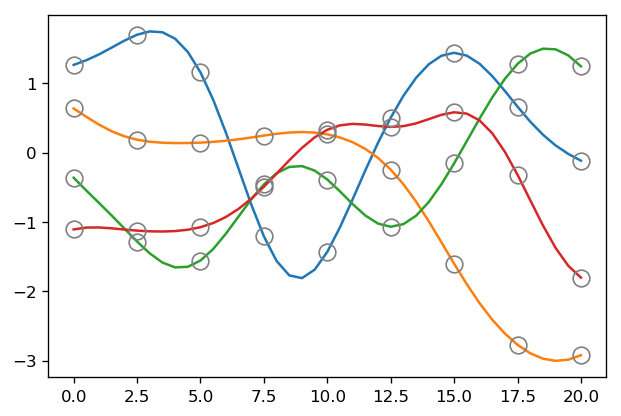

In [7]:
# Instantiate a Gaussian Process model
gp = GaussianProcessRegressor(kernel=true_kernel, n_restarts_optimizer=9, optimizer=None)
# gp.fit()
toy_data_full = gp.sample_y(X_full, n_samples=n_samples, random_state=seed).T
mean_full, cov_full = gp.predict(X_full, return_cov=True)

# toy_data_full *= (ratio**orders)[:, None]
toy_data = toy_data_full[:, mask]
mean = mean_full[mask]
cov = cov_full[mask][:, mask]
X = X_full[mask]

plt.plot(X_full.ravel(), toy_data_full.T);
plt.plot(X.ravel(), toy_data.T, ls='', marker='o', fillstyle='none', markersize=10, c='gray');

Now if we take the data shown above, estimate the hyperparameters using conjugacy, and fit to the data, we get the plot shown below:

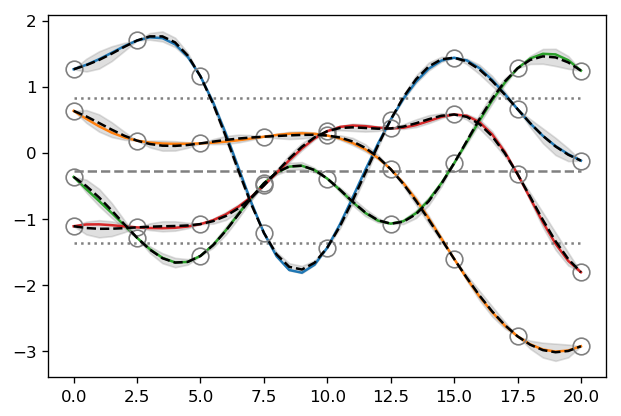

In [8]:
my_gp = ConjugateGaussianProcess(kernel)
my_gp.fit(X, toy_data)
# X_new = X_full[~mask]
# toy_data_pred = toy_data_full[:, ~mask]
X_new = X_full
toy_data_pred = toy_data_full
# my_gp.beta()
m_pred, K_pred = my_gp.predict(X_new, return_cov=True, pred_noise=True)
# print(np.diag(K_pred))
sd_pred = np.sqrt(np.diag(K_pred))

# Plot the underlying process
plt.plot(X.ravel(), my_gp.mean(), ls='--', c='gray')
plt.plot(X.ravel(), my_gp.mean() + my_gp.sd(), ls=':', c='gray')
plt.plot(X.ravel(), my_gp.mean() - my_gp.sd(), ls=':', c='gray');

# Now the true data
plt.plot(X_full.ravel(), toy_data_full.T);
plt.plot(X.ravel(), toy_data.T, ls='', marker='o', fillstyle='none', markersize=10, c='gray');

# The predicted interpolants and their errors
plt.plot(X_new.ravel(), m_pred.T, c='k', ls='--', label='pred');
for m in m_pred:
    plt.fill_between(X_new.ravel(), m + 2*sd_pred, m - 2*sd_pred, color='gray', alpha=0.25)
# plt.legend();

It worked! The mean and standard deviation are determined fairly well from the data. Not only that, the fits seem to interpolate in a reasonable manner. This should be expected, since the toy data were generated from a single GP whose kernel was assumed to be known. Plus, the length scale was fixed at the correct value.

We can do better than these "by eye" checks. What does B&O model checking say about this case? First, assume that we are checking the underlying process, shown by the constant gray dotted/dashed lines above, against the colored draws.

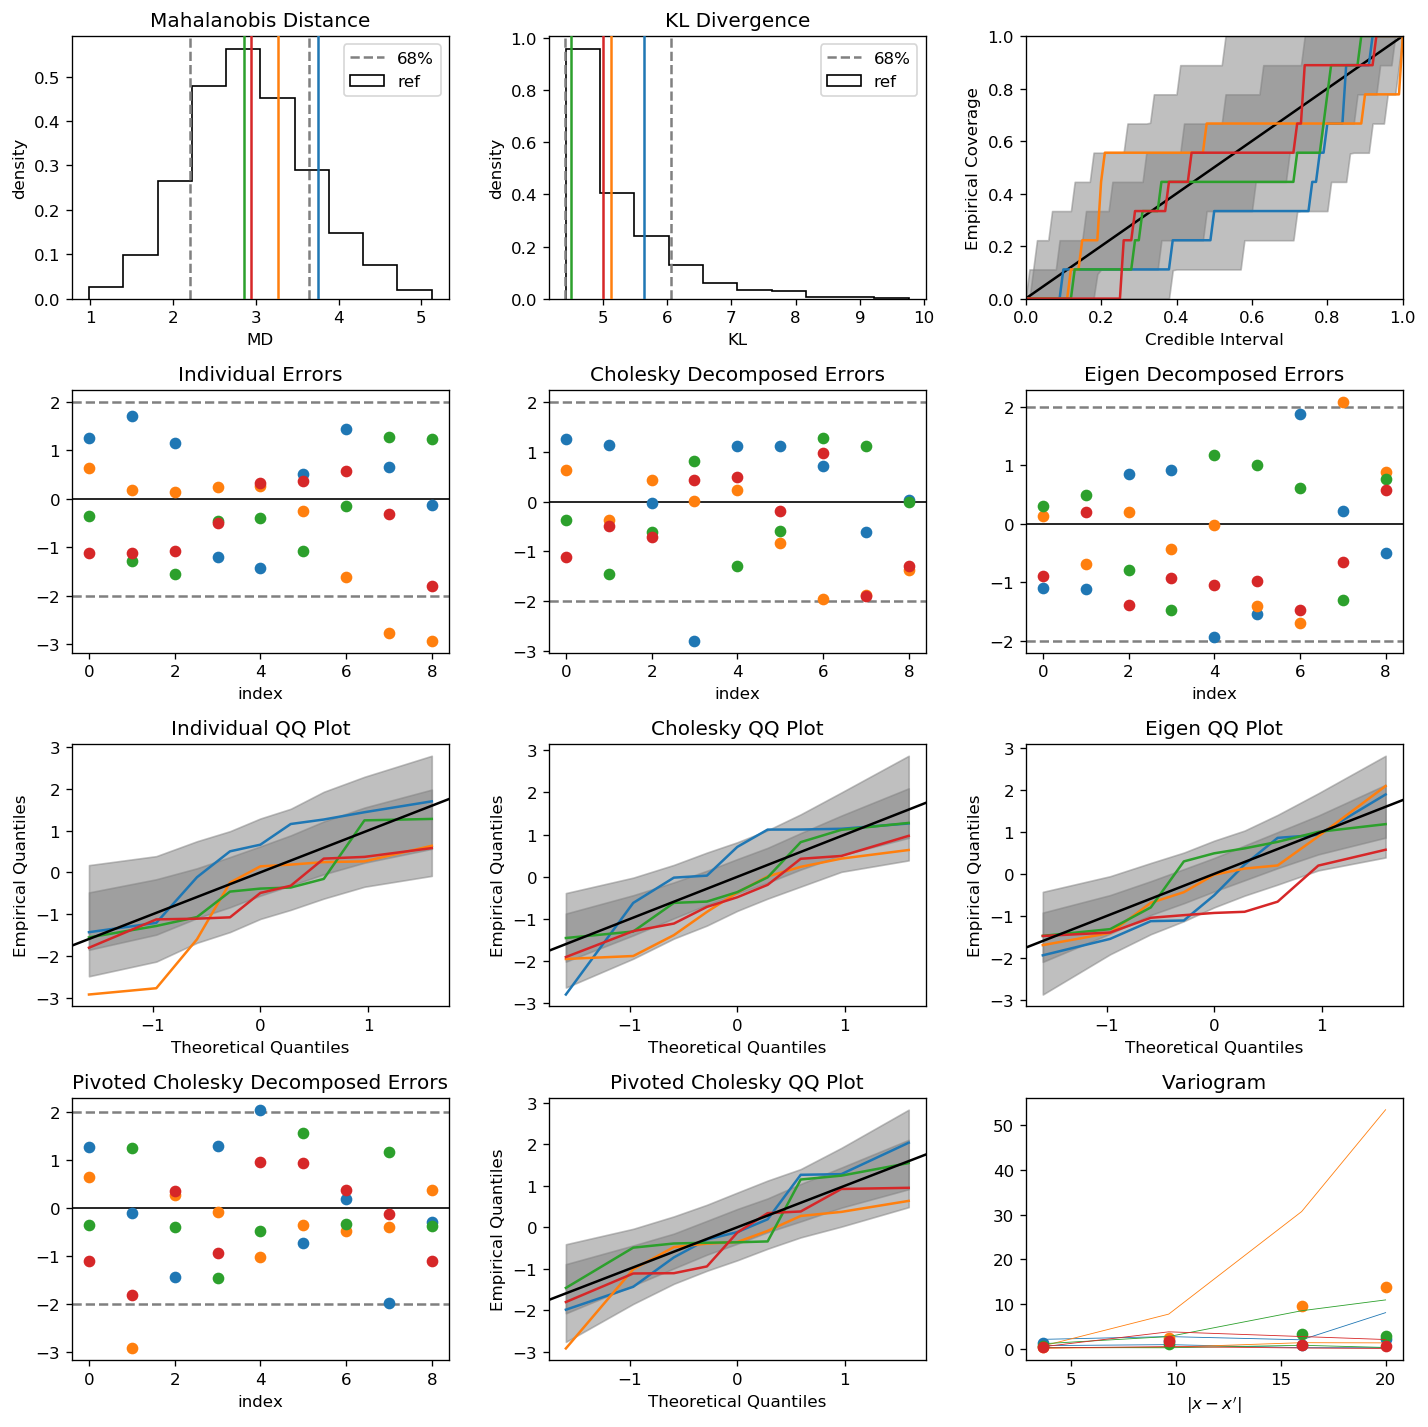

In [9]:
np.random.seed(seed)
gp = ConjugateGaussianProcess(kernel)
gpmc = Diagnostic(mean, cov)
gd = GraphicalDiagnostic(gpmc, toy_data, nref=n_ref)
gd.plotzilla(X, gp, vlines=vlines);

They each are within errors, as expected.

What if we use the full dataset?

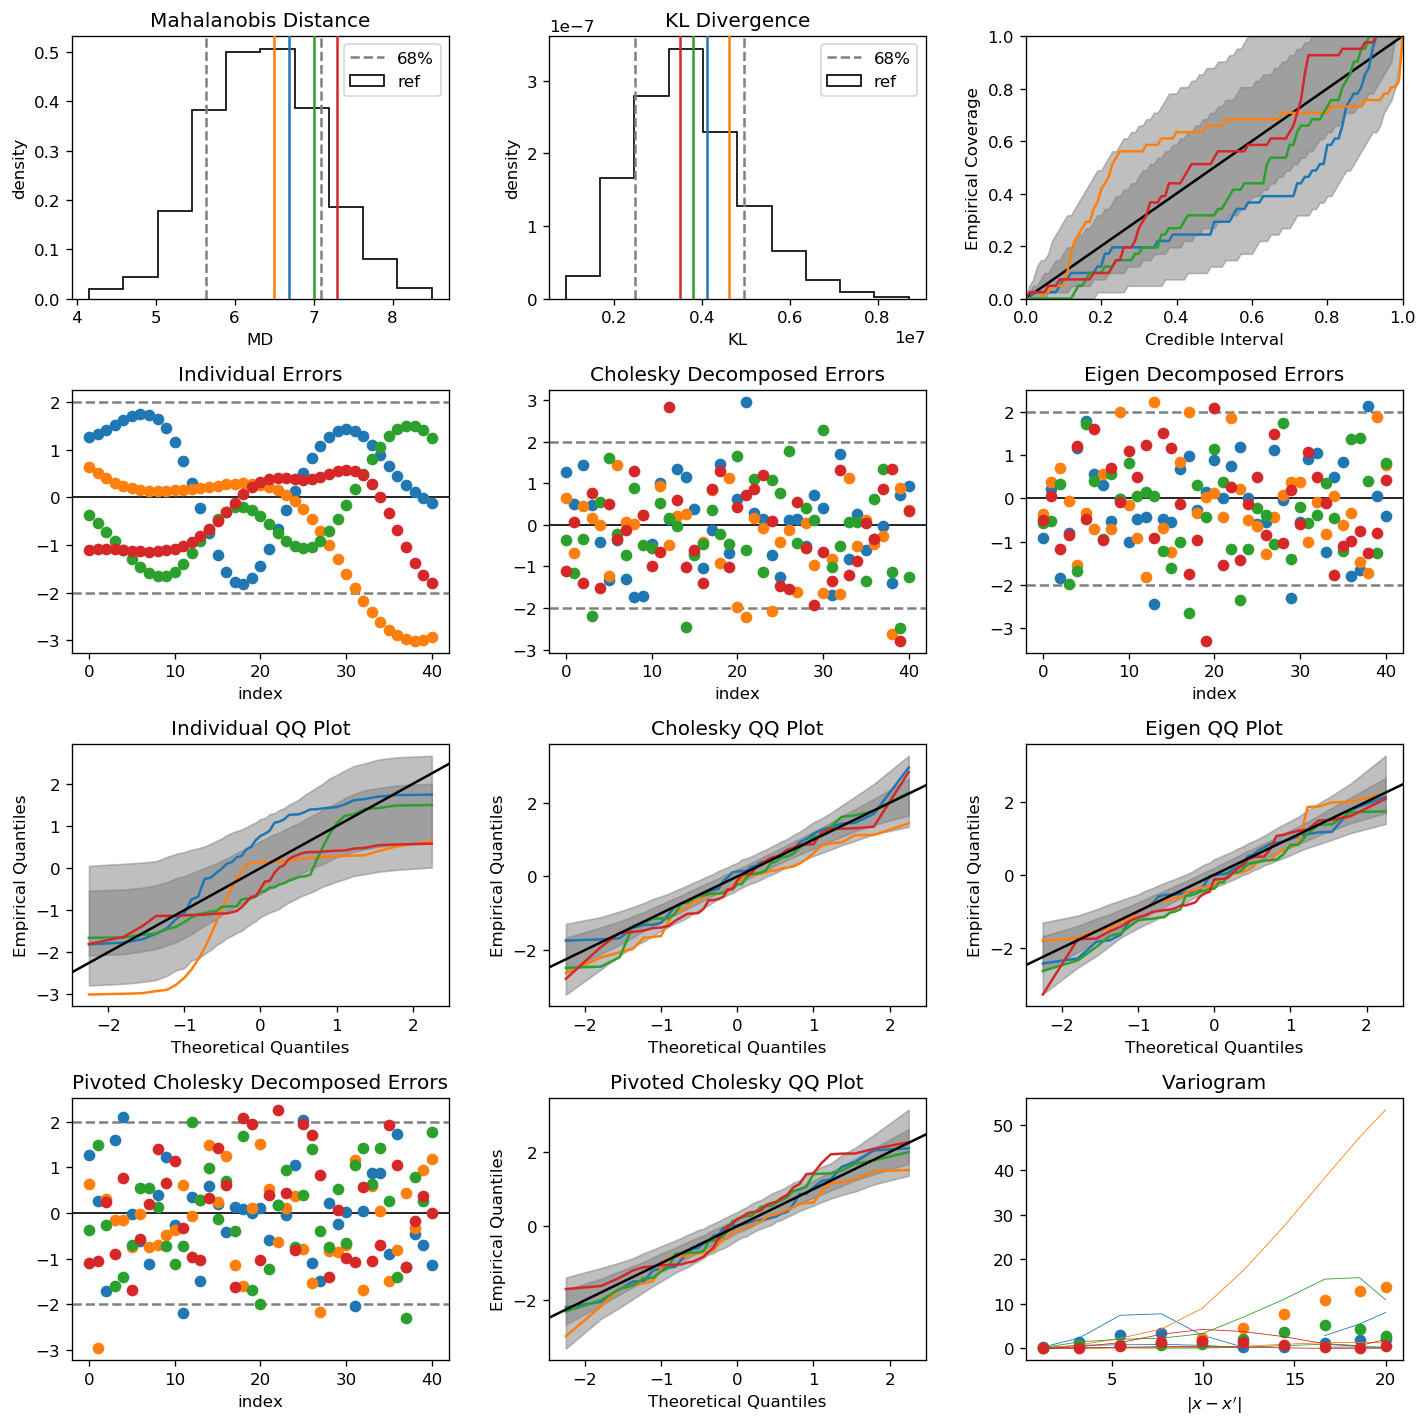

In [10]:
gp = ConjugateGaussianProcess(kernel)
gpmc_full = Diagnostic(mean_full, cov_full)
gd_full = GraphicalDiagnostic(gpmc_full, toy_data_full, nref=n_ref)
gd_full.plotzilla(X_full, gp, vlines=vlines);

What if we performed the same model checking with the interpolants?
This time, we are comparing each colored curve to the process defined by the thin gray bands around that curve.
One potential clever way to combine the diagnostics from interpolated processes relies on the fact that the only thing that is different about the interpolating processes is their mean function that interpolates the data. If we subtract the means off the process and the data, then we are back to the simple iid case.

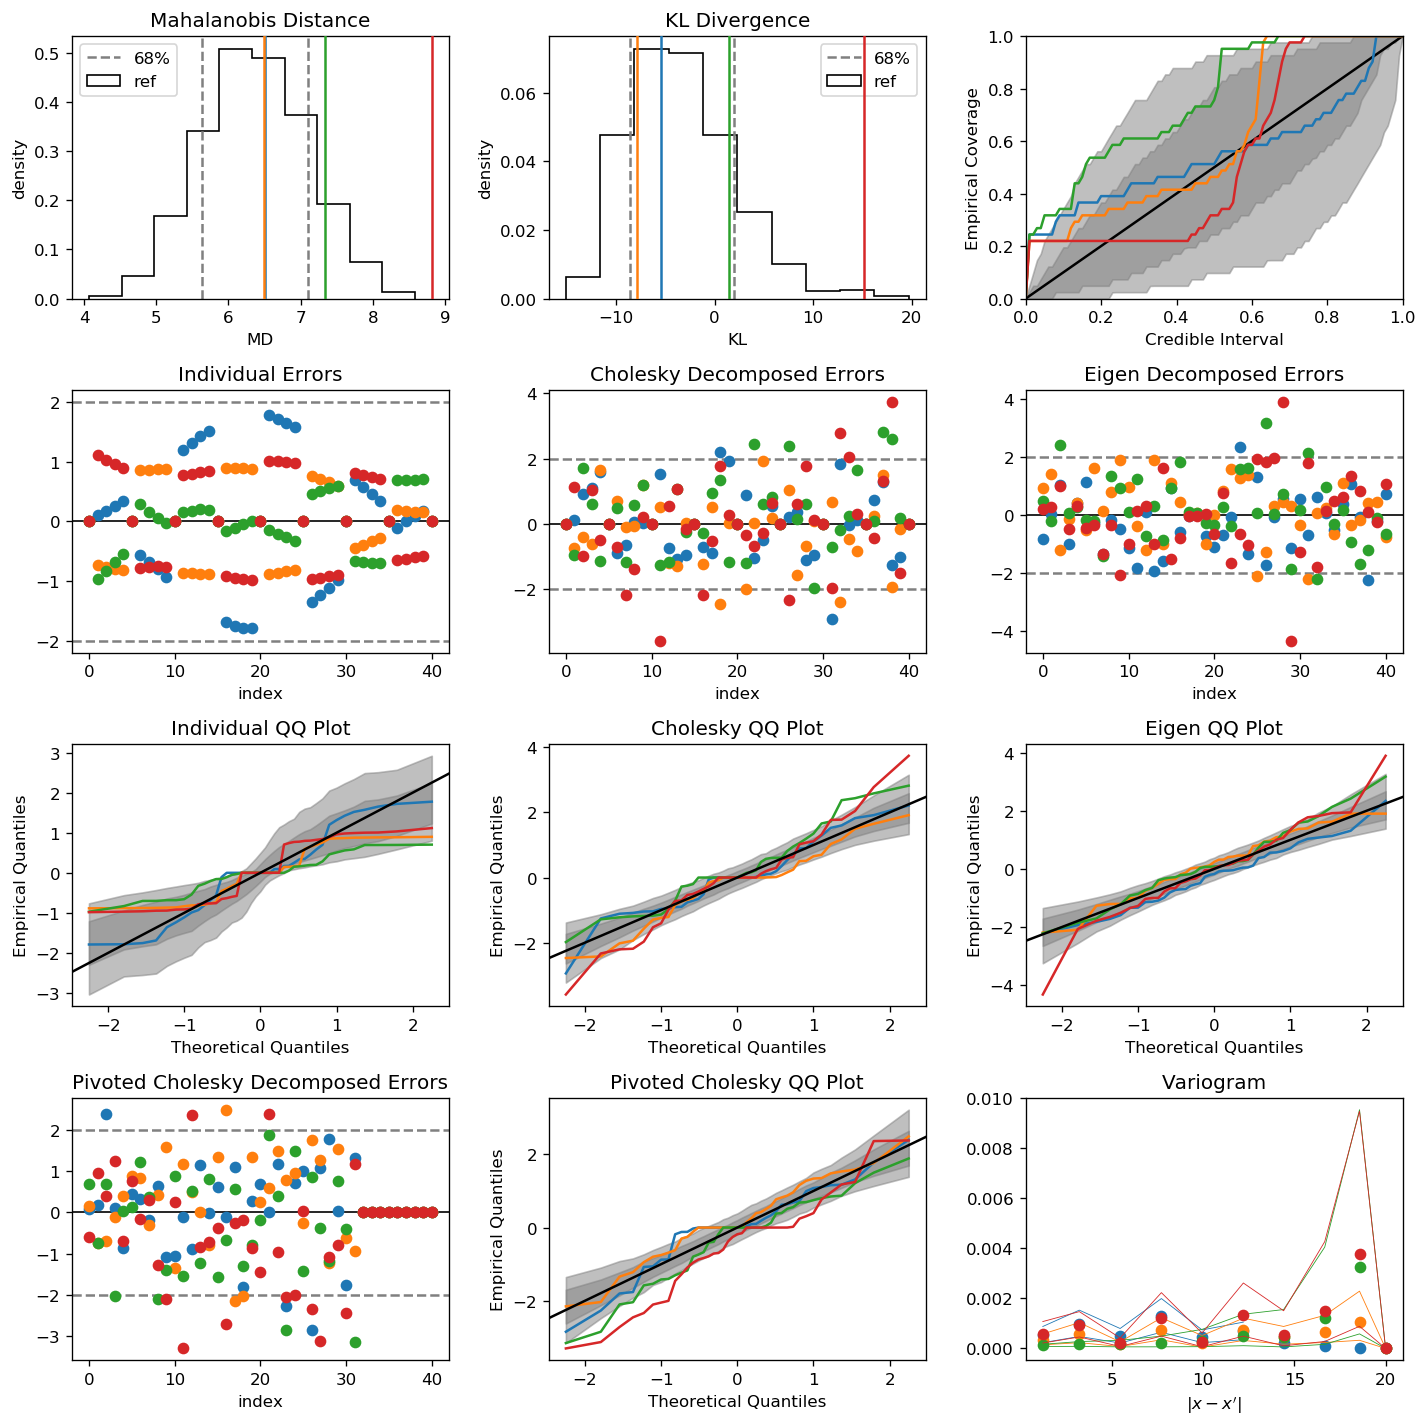

In [11]:
np.random.seed(seed)
gp = ConjugateGaussianProcess(kernel)
gp.fit(X, toy_data, noise_sd=nugget_sd)
mean_est, cov_est = gp.predict(X_new, return_cov=True, pred_noise=True)
# print(mean_est.shape)
gpmc = Diagnostic(np.zeros(mean_est.shape[1]), K_pred + nugget_sd**2 * np.eye(K_pred.shape[0]))
# gpmc = GPModelChecking(np.zeros_like(mean_est[0]), cov_est, df=2*gp.a())
gd = GraphicalDiagnostic(gpmc, toy_data_pred - mean_est, nref=n_ref)
gd.plotzilla(X_new, gp, predict=True, vlines=vlines);

These all look good! We should note that a nugget should be used across **all** covariances or else problems with ill-conditioned matrices arise.

## Learning the length scale



So far we have assumed that the length scale is known, but what if we want to estimate it from data?
I have changed the API for the `ConjugateGaussianProcess` class so that the kernel keyword arguments are passed during the initialization of the object.
Thus, if you want the kernel keywords fixed, pass `kernel_kws={'ls': 0.5, ...}`, and everytime the correlation matrix is constructed, it will use those keywords.

Sometimes we want the keywords to be estimated during the `fit` method.
Because kernels can depend on many hyperparameters, any of which could be important or uninteresting to vary, the mesh of hyperparameters must currently be created by hand.
*(I'm thinking about implementing some sort of automatic search like `scikit-learn` performs, maybe that will come soon.)*
So instead of passing one dictionary, one must pass a list of dictionaries to the constructor as in `kernel_kws=[{'ls': 0.1}, {'ls': 0.2}, ... {'ls': 1.}]`.
When `fit` is called, the best hyperparameters will be chosen and assigned to the kernel.
If `fit` is called again with different data, then a new best set of hyperparameters will be found and will override the previous choice.

In [12]:
ls_mesh = np.linspace(0.1, 7, 100)
gp = ConjugateGaussianProcess(rbf, kernel_kws=[{'ls': ls} for ls in ls_mesh])
gp.fit(X, toy_data, noise_sd=nugget_sd)

Setting kernel kwargs to {'ls': 3.2363636363636368}


One could also call the `likelihood` method directly with a set of correlation matrices to test.
This is essentially what's done under the hood during the fit.

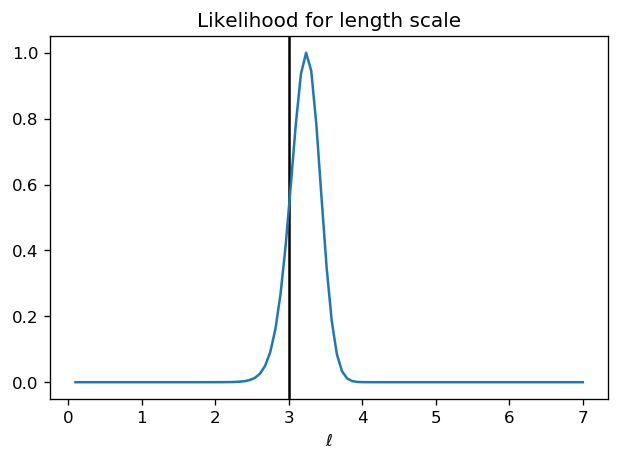

In [13]:
Rs = np.array([rbf(X, X, ls=L) for L in ls_mesh])

ls_loglike = gp.likelihood(log=True, X=X, corr=Rs)
ls_like = np.exp(ls_loglike - np.max(ls_loglike))

ax = plt.gca()
ax.set_xlabel(r'$\ell$')
ax.set_title('Likelihood for length scale')
ax.axvline(ls_true, 0, 1, c='k')
ax.plot(ls_mesh, ls_like);

This is how diagnostic tests could work when kernel hyperparameters are fit

Setting kernel kwargs to {'ls': 3.2363636363636368}


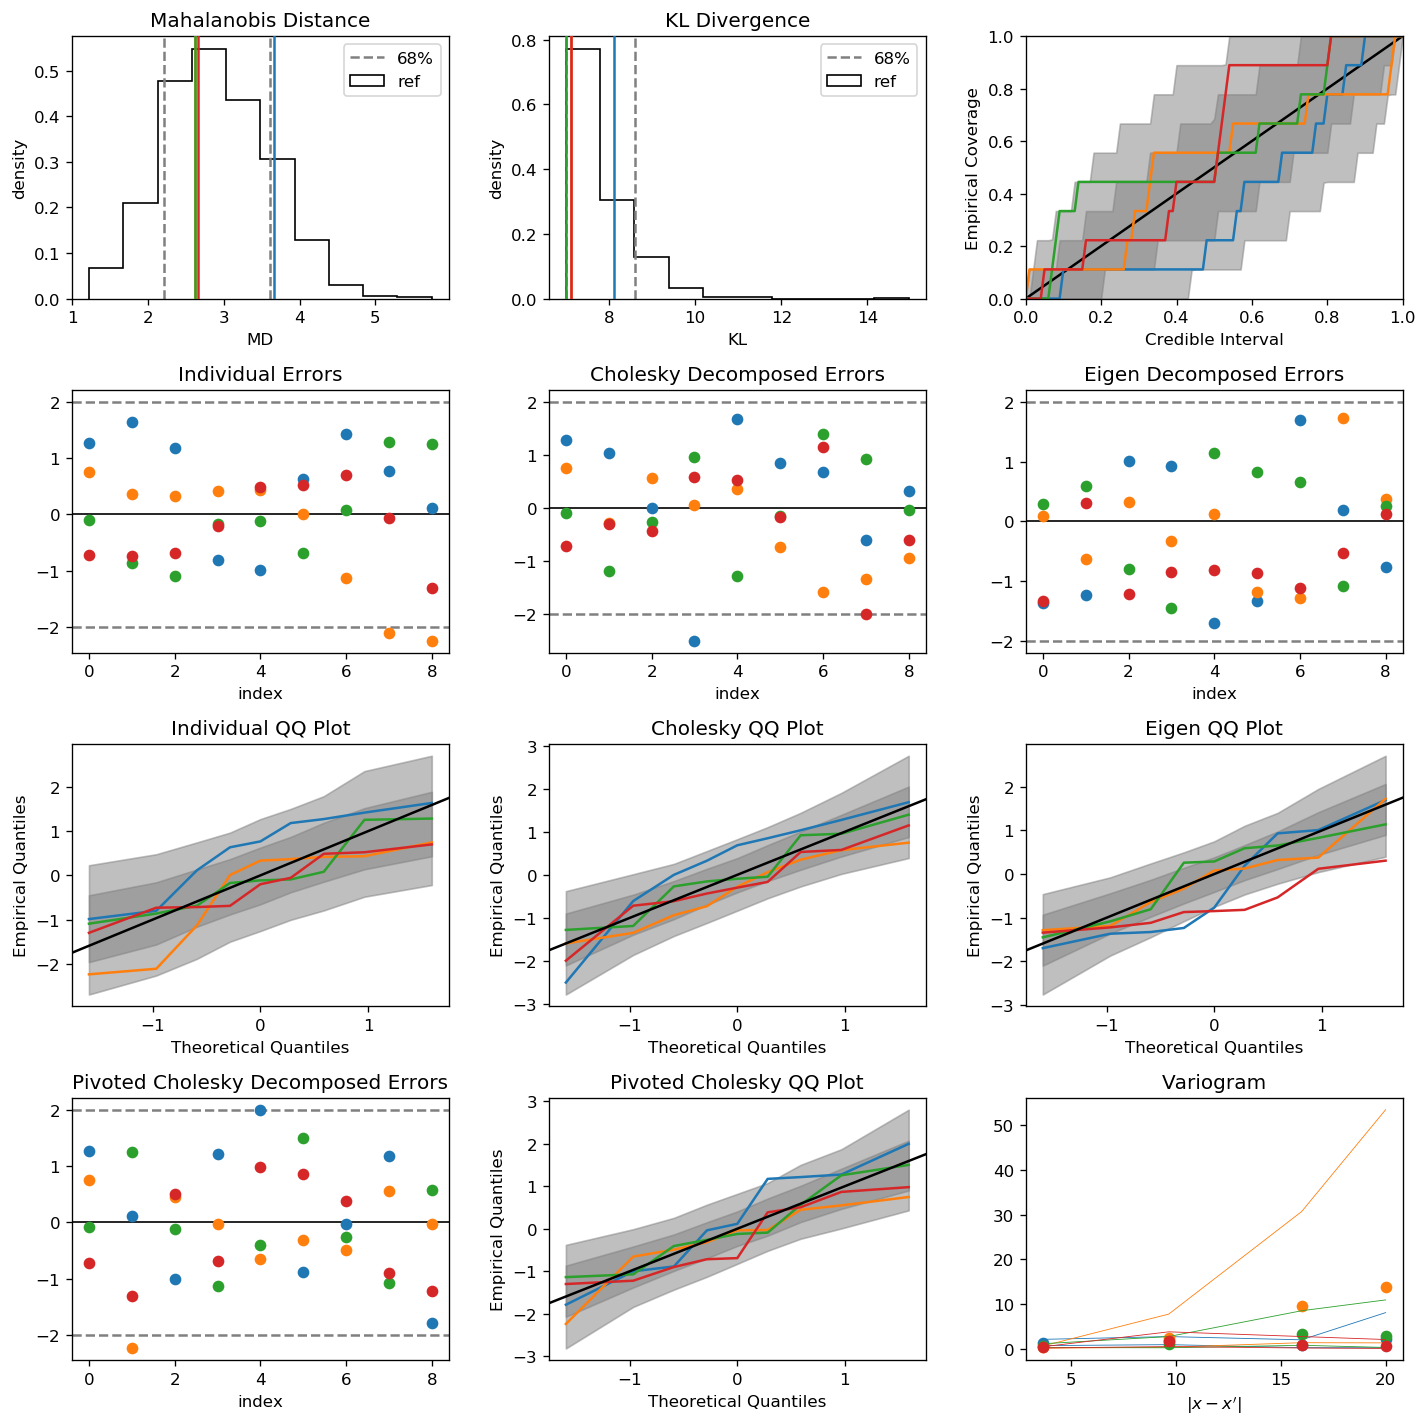

In [14]:
ls_mesh = np.linspace(0.1, 7, 100)
gp = ConjugateGaussianProcess(rbf, kernel_kws=[{'ls': ls} for ls in ls_mesh])
gp.fit(X, toy_data, noise_sd=nugget_sd)
best_fit = gp.kernel_kws  # These are updated by the fit

# Don't update the fit everytime you see new data, that takes too long. just use MAP values from now on
gp_static = ConjugateGaussianProcess(rbf, kernel_kws=best_fit)
mean_est, cov_est = gp.mean(), gp.cov()

gpmc = Diagnostic(mean_est, cov_est)
gd = GraphicalDiagnostic(gpmc, toy_data, nref=n_ref)
gd.plotzilla(X, gp_static, vlines=vlines);

And for predictions too. Because the hyperparameter estimation actually worked well, things work out pretty much as before:

Setting kernel kwargs to {'ls': 3.2363636363636368}


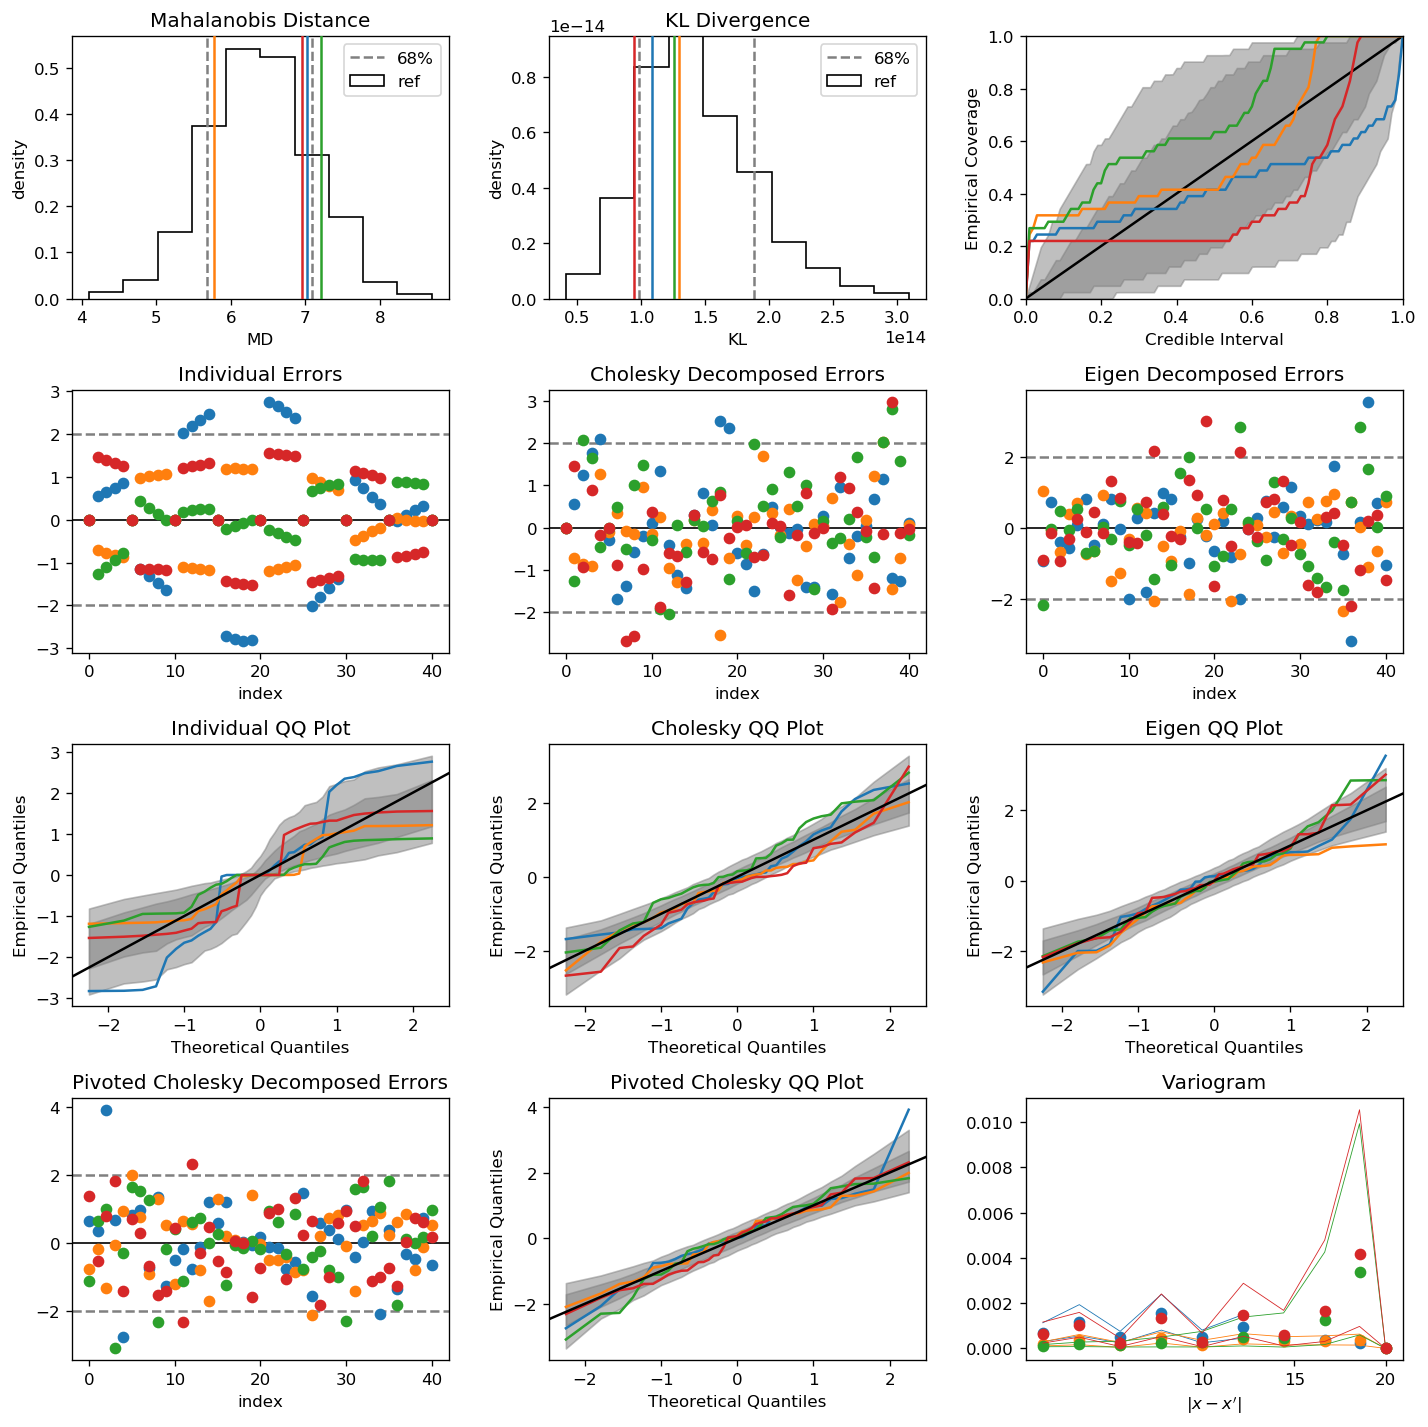

In [15]:
ls_mesh = np.linspace(0.1, 7, 100)
gp = ConjugateGaussianProcess(rbf, kernel_kws=[{'ls': ls} for ls in ls_mesh])
gp.fit(X, toy_data, noise_sd=nugget_sd)
best_fit = gp.kernel_kws  # These are updated by the fit

# Don't update the fit everytime you see new data, that takes too long. just use MAP values from now on
gp_static = ConjugateGaussianProcess(rbf, kernel_kws=best_fit)
mean_est, cov_est = gp.predict(X_new, return_cov=True, pred_noise=True)

gpmc = Diagnostic(np.zeros(mean_est.shape[1]), cov_est)
gd = GraphicalDiagnostic(gpmc, toy_data_pred-mean_est, nref=n_ref)
gd.plotzilla(X_new, gp_static, vlines=vlines);

## Todo

I want to improve the code, check for bugs/errors, add more examples, and add more model checking diagnostics. We must find where the model fails, and which diagnostics are most helpful when accepting/rejecting the model.

In [16]:
# ratio_param = np.linspace(0.1, 2, 20)
# ratios = ratio_param[:, None] * np.ones(len(X))
# joint_loglike = gp.ratio_likelihood(ratios, toy_data, cholRs)
# joint_like = np.exp(joint_loglike - np.max(joint_loglike))

In [17]:
# print(ratio_param.shape, ls_mesh.shape, joint_like.shape)
# fig, axes = plt.subplots(1, 2, figsize=(10, 4))
# axes[0].contourf(ratio_param, ls_mesh, joint_loglike.T);
# axes[1].contourf(ratio_param, ls_mesh, np.exp(joint_loglike).T);

# axes[0].set_title(r'Joint log likelihood pr$(D | \ell, Q)$')
# axes[0].set_xlabel(r'$Q$ scale')
# axes[0].set_ylabel(r'$\ell$');

# axes[1].set_title(r'Joint likelihood pr$(D | \ell, Q)$')
# axes[1].set_xlabel(r'$Q$ scale')
# axes[1].set_ylabel(r'$\ell$');

In [18]:
# Q_ell_idx = np.argmax(joint_loglike)
# Q_ell_idx = np.unravel_index(Q_ell_idx, joint_loglike.shape)
# print(Q_ell_idx)
# Q_ml, ell_ml = ratio_param[Q_ell_idx[0]], ls_mesh[Q_ell_idx[1]]
# print('Best Q:', Q_ml, 'Best ell:', ell_ml)
# print('True Q:', ratio, 'True ell:', ls_true)